Iterations ENKF <class 'model1_class.Model1'>:   8%|▊         | 31/396 [00:09<01:50,  3.31it/s]

this is X [[ 6.28450387e+06  1.62021022e+06  3.38602144e+06 ...  1.24840090e+07
   5.05295198e+06  4.39375758e+06]
 [-2.98590237e+05  2.30964561e+04  1.24288234e+06 ... -6.28628582e+05
   4.91016193e+05  5.98366189e+05]
 [ 9.26574441e+04  3.39342515e+05  9.68424067e+05 ...  1.73700113e+06
   1.55668958e+06  7.25150244e+05]
 ...
 [ 2.35062014e+02  8.94082095e+02  1.52390493e+03 ...  1.59742573e+03
   2.29956615e+03  1.28976352e+03]
 [ 8.82268164e+01  9.92506416e+02  7.61733034e+02 ...  1.51683816e+03
   2.02934393e+03  6.45960826e+02]
 [ 1.79137607e+02  9.79800924e+02  8.73541730e+02 ...  9.38065987e+02
   1.86248643e+03  2.02300615e+02]]


Iterations ENKF <class 'model1_class.Model1'>:   8%|▊         | 32/396 [00:09<01:47,  3.40it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  15%|█▌        | 61/396 [00:17<01:52,  2.99it/s]

this is X [[6.98650613e+06 3.31757605e+06 3.92839828e+06 ... 1.23067321e+07
  6.86362489e+06 5.13509629e+06]
 [2.40277461e+05 1.16323283e+06 2.15955084e+06 ... 1.86855678e+06
  2.09153144e+06 1.66201874e+06]
 [2.95400591e+05 7.73593537e+05 1.61632104e+06 ... 1.08932127e+06
  1.49937583e+06 1.22721815e+06]
 ...
 [8.54684854e+00 8.59998161e+02 1.55413127e+03 ... 1.41970526e+03
  2.09029279e+03 9.61092017e+02]
 [8.46979107e+00 8.63131155e+02 8.98100437e+02 ... 1.36678262e+03
  1.90767124e+03 3.61465678e+02]
 [2.08444705e+01 8.94779111e+02 8.33669160e+02 ... 8.59736590e+02
  1.84092142e+03 1.54404884e+02]]


c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  23%|██▎       | 91/396 [00:26<01:23,  3.64it/s]

this is X [[8.46735049e+06 5.57909794e+06 4.90560683e+06 ... 1.24391495e+07
  8.56603756e+06 6.63986890e+06]
 [5.78380389e+05 1.53115357e+06 1.83415865e+06 ... 1.44515966e+06
  2.43217617e+06 1.80086741e+06]
 [4.18657454e+05 8.68096260e+05 1.36003476e+06 ... 1.08047505e+06
  1.60232744e+06 1.24557483e+06]
 ...
 [1.13274987e+01 9.88587474e+02 1.20443176e+03 ... 1.05345676e+03
  2.07311677e+03 6.53413211e+02]
 [7.69535335e+00 9.58414182e+02 6.11744988e+02 ... 1.07124333e+03
  1.88161577e+03 1.20550640e+02]
 [3.85935657e+01 9.51086803e+02 7.14267593e+02 ... 6.95542885e+02
  1.85776490e+03 9.72930308e+01]]


Iterations ENKF <class 'model1_class.Model1'>:  31%|███       | 121/396 [00:35<01:14,  3.68it/s]

this is X [[8.04068618e+06 6.96385929e+06 5.90642683e+06 ... 1.55572100e+07
  9.69285939e+06 6.08776606e+06]
 [1.13662619e+06 2.26401709e+06 2.54733101e+06 ... 2.25670133e+06
  2.94414673e+06 1.98097331e+06]
 [8.09700596e+05 1.11566003e+06 1.63288125e+06 ... 1.53597847e+06
  1.86965768e+06 1.46393429e+06]
 ...
 [9.55957381e-01 1.03161183e+03 1.02170019e+03 ... 1.05024014e+03
  2.24342159e+03 6.65429155e+02]
 [8.87567554e+00 9.98905535e+02 7.26901694e+02 ... 1.03333497e+03
  1.93867611e+03 1.37217023e+02]
 [2.01223263e+01 1.01242065e+03 6.56917901e+02 ... 7.11598345e+02
  1.89143532e+03 9.46491659e+01]]


Iterations ENKF <class 'model1_class.Model1'>:  38%|███▊      | 151/396 [00:44<01:07,  3.65it/s]

this is X [[ 8.32839678e+06  7.80297565e+06  6.97788038e+06 ...  1.63853674e+07
   9.97702406e+06  7.28107895e+06]
 [ 1.48436577e+06  2.30106834e+06  3.52063074e+06 ...  2.70626044e+06
   3.02427836e+06  2.08900894e+06]
 [ 1.04563903e+06  1.16177903e+06  1.87615182e+06 ...  1.99732068e+06
   2.10267948e+06  1.53080198e+06]
 ...
 [-7.59279234e+01  9.79292568e+02  1.09967301e+03 ...  1.00208017e+03
   2.14636274e+03  6.27056752e+02]
 [-5.19964262e+01  9.72093218e+02  7.93526486e+02 ...  9.91322594e+02
   1.87867038e+03  1.14424847e+02]
 [ 1.92037220e+00  1.00190113e+03  7.21900910e+02 ...  6.80457222e+02
   1.86510651e+03  1.08551064e+02]]


Iterations ENKF <class 'model1_class.Model1'>:  46%|████▌     | 181/396 [00:53<00:57,  3.75it/s]

this is X [[9.26528471e+06 9.29239490e+06 7.73033016e+06 ... 1.70170521e+07
  1.03317528e+07 8.42899124e+06]
 [2.27830890e+06 3.20871952e+06 4.67437771e+06 ... 3.69061237e+06
  3.45872542e+06 2.96962521e+06]
 [1.31213188e+06 1.47675272e+06 2.43412438e+06 ... 2.48235309e+06
  2.47547908e+06 1.92857015e+06]
 ...
 [4.37150647e+01 1.04974650e+03 1.03866428e+03 ... 9.52179126e+02
  2.04209406e+03 6.11190092e+02]
 [5.20021354e+01 1.03862015e+03 7.85937566e+02 ... 9.68873472e+02
  1.81483093e+03 1.27763754e+02]
 [4.75082357e+01 1.03714301e+03 7.60929696e+02 ... 6.70576312e+02
  1.85253299e+03 1.50603318e+02]]


Iterations ENKF <class 'model1_class.Model1'>:  53%|█████▎    | 211/396 [01:02<00:50,  3.63it/s]

this is X [[ 9.23368664e+06  1.03866650e+07  9.95860010e+06 ...  2.05859783e+07
   1.14095058e+07  1.03653274e+07]
 [ 1.97539214e+06  3.08981206e+06  3.54907910e+06 ...  4.32136431e+06
   3.06694345e+06  3.04365994e+06]
 [ 1.50446097e+06  1.83352606e+06  2.52442567e+06 ...  3.04125213e+06
   2.75318391e+06  2.42857140e+06]
 ...
 [-8.60817407e+01  8.61514382e+02  9.17316454e+02 ...  8.54062728e+02
   1.84059812e+03  4.62265611e+02]
 [-4.50755261e+01  9.20676083e+02  6.94609730e+02 ...  8.84987373e+02
   1.77625365e+03  6.60070375e+01]
 [ 4.65309009e+01  1.07544154e+03  8.15075119e+02 ...  7.27004050e+02
   1.83101449e+03  1.84710156e+02]]


Iterations ENKF <class 'model1_class.Model1'>:  61%|██████    | 241/396 [01:12<00:47,  3.28it/s]

this is X [[ 9.59630961e+06  1.08188967e+07  9.25330791e+06 ...  2.00343911e+07
   1.27867357e+07  9.37639742e+06]
 [ 1.94881730e+06  3.30347557e+06  3.20109125e+06 ...  3.30113704e+06
   3.40323106e+06  2.75328733e+06]
 [ 1.57573719e+06  2.07186680e+06  2.39420633e+06 ...  2.90774304e+06
   3.18304745e+06  2.47509098e+06]
 ...
 [-2.84797208e+01  4.62927972e+02 -2.18754922e+01 ...  6.81129315e+02
   1.28870523e+03  2.13636504e+02]
 [-2.50270772e+01  1.24823148e+02 -2.23731279e+01 ...  6.75987919e+02
   1.28813722e+03  1.47419273e+02]
 [-1.57814524e+01 -2.03790145e+01  1.76409455e+00 ...  2.50417696e+02
   1.21122457e+03  5.66815302e+01]]


Iterations ENKF <class 'model1_class.Model1'>:  68%|██████▊   | 271/396 [01:20<00:35,  3.49it/s]

this is X [[ 1.10603713e+07  1.10076269e+07  1.11708812e+07 ...  1.92431893e+07
   1.15939286e+07  8.89489132e+06]
 [ 1.99510375e+06  2.96087332e+06  3.80374230e+06 ...  2.06887248e+06
   2.20879007e+06  1.79090333e+06]
 [ 1.55062413e+06  2.03994788e+06  2.58215221e+06 ...  2.83440446e+06
   2.98873182e+06  2.09930172e+06]
 ...
 [-5.88259096e+00  4.40399522e+02  4.43324758e+00 ...  6.38082172e+02
   1.25471740e+03  1.91703052e+02]
 [-1.01762111e+01  1.01757618e+02  4.62778674e+00 ...  6.33601136e+02
   1.24948537e+03  1.20508518e+02]
 [-1.65329444e+01 -1.12196217e+01 -5.89416507e+00 ...  2.59468174e+02
   1.20316464e+03  5.11894833e+01]]


Iterations ENKF <class 'model1_class.Model1'>:  76%|███████▌  | 301/396 [01:31<00:47,  2.01it/s]

this is X [[ 1.12618119e+07  1.15206053e+07  1.23094138e+07 ...  2.11053748e+07
   1.35320515e+07  9.54794700e+06]
 [ 2.14786952e+06  2.95548474e+06  3.84096438e+06 ...  2.85430869e+06
   2.82693059e+06  1.86465919e+06]
 [ 1.68845661e+06  2.14058211e+06  2.74869822e+06 ...  3.00882951e+06
   2.27012390e+06  1.93548375e+06]
 ...
 [-3.43865553e+01  3.92175220e+02 -5.90346103e+01 ...  6.09353713e+02
   1.17517086e+03  7.75864668e+01]
 [-2.55725344e+01  6.32817019e+01 -4.74692504e+01 ...  6.05110252e+02
   1.17453681e+03  3.65695902e+01]
 [-3.35373953e+00 -1.76795926e+01 -2.67915212e+01 ...  2.43353842e+02
   1.16351279e+03 -2.37465779e+00]]


Iterations ENKF <class 'model1_class.Model1'>:  84%|████████▎ | 331/396 [01:39<00:17,  3.76it/s]

this is X [[ 1.25318181e+07  1.17749370e+07  1.22153727e+07 ...  2.25079141e+07
   1.50004891e+07  9.83654306e+06]
 [ 2.40825596e+06  3.42856555e+06  3.62946040e+06 ...  3.21654910e+06
   3.45391567e+06  1.67518789e+06]
 [ 1.71546986e+06  2.42872739e+06  2.67684458e+06 ...  3.44840282e+06
   2.90657062e+06  1.87140723e+06]
 ...
 [ 2.22783129e+01  4.82141223e+01  2.20848088e+01 ...  5.85251613e+02
   8.84606947e+02 -2.68487888e+01]
 [ 1.97002569e+01  3.72479796e+01  1.31739651e+01 ...  5.81221116e+02
   8.95787958e+02 -2.20756380e+01]
 [ 1.58713713e+01  3.06585499e+01  1.60238479e+01 ...  2.31002235e+02
   8.96933755e+02 -3.94882880e+01]]


Iterations ENKF <class 'model1_class.Model1'>:  91%|█████████ | 361/396 [01:47<00:09,  3.50it/s]

this is X [[1.36108603e+07 1.37764215e+07 1.11437708e+07 ... 2.41436486e+07
  1.75356368e+07 1.08620115e+07]
 [2.91200397e+06 4.23015577e+06 3.36442429e+06 ... 3.68747230e+06
  4.76962210e+06 2.10690567e+06]
 [2.04649427e+06 2.68118036e+06 2.72681242e+06 ... 3.38998196e+06
  3.62859564e+06 1.94919544e+06]
 ...
 [3.89925848e+01 7.10596262e+01 4.34585128e+01 ... 4.50054344e+02
  8.44313721e+02 3.13893055e+01]
 [3.29221635e+01 5.93366338e+01 2.43814264e+01 ... 4.11057289e+02
  8.35608756e+02 2.49349718e+01]
 [2.58220755e+01 4.83111603e+01 2.10133458e+01 ... 2.41805024e+02
  8.24166169e+02 2.10119270e+01]]


Iterations ENKF <class 'model1_class.Model1'>:  99%|█████████▊| 391/396 [01:58<00:01,  3.41it/s]

this is X [[1.54873233e+07 1.58208202e+07 1.19577723e+07 ... 2.64374865e+07
  1.88624898e+07 1.25891691e+07]
 [3.76392010e+06 5.27197726e+06 3.83476114e+06 ... 3.39842689e+06
  4.95928170e+06 2.78209567e+06]
 [2.38278650e+06 3.04235673e+06 3.06841126e+06 ... 3.59384628e+06
  3.68780162e+06 2.18762994e+06]
 ...
 [5.50545600e+01 8.60578699e+01 4.40333832e+01 ... 4.53676764e+02
  8.50554733e+02 3.99167445e+01]
 [4.88289228e+01 7.62051780e+01 2.53155895e+01 ... 4.10246705e+02
  8.39850820e+02 3.54303332e+01]
 [3.90615247e+01 6.22684305e+01 2.12351540e+01 ... 2.43234240e+02
  8.27882418e+02 2.94491134e+01]]


Iterations ENKF <class 'model2_class.Model2'>:   8%|▊         | 31/396 [00:43<08:35,  1.41s/it]

this is X [[ 8.76937768e+06  3.73390974e+06  4.79992391e+06 ...  4.80645444e+06
   4.45855920e+06  1.93546883e+06]
 [ 1.17954991e+06  3.78193501e+05  3.43943438e+06 ...  4.34621216e+05
  -1.03928583e+06  1.25129193e+06]
 [ 1.08141619e+06  3.40481698e+06  5.18973709e+06 ...  1.51748361e+06
   2.30783570e+05  1.71354276e+06]
 ...
 [ 1.59102636e+03  4.62203722e+03  4.30061163e+02 ...  1.19326813e+02
   2.14103983e+03  7.66249796e+02]
 [ 1.33192794e+03  6.31722823e+02  4.82501455e+02 ...  5.21396208e+02
   2.12352403e+03  7.19435740e+02]
 [ 2.49726747e+02  8.37249041e+01 -1.63683271e+02 ...  3.96874646e+01
   7.54803200e+02  1.74177843e+02]]


Iterations ENKF <class 'model2_class.Model2'>:  15%|█▌        | 61/396 [00:53<01:45,  3.18it/s]

this is X [[ 1.25203010e+07  7.96508726e+06  7.26107230e+06 ...  7.79893886e+06
   6.62020222e+06  1.16810052e+07]
 [ 1.96187977e+06  1.65721378e+06  5.50420157e+06 ...  4.02049326e+06
   1.92785020e+06  4.42167793e+06]
 [ 2.01186889e+06  2.67850658e+06  5.50326820e+06 ...  2.49649628e+06
   1.83297992e+06  1.06714960e+06]
 ...
 [ 6.99654453e+02  1.35964848e+03  6.29830601e+01 ... -5.56869206e+02
   1.56753555e+03  8.50542779e+00]
 [ 9.54009721e+02  1.89310757e+02  1.07517968e+02 ... -5.63427438e+02
  -1.14176537e+01  1.58902206e+02]
 [ 3.95156228e+01 -3.09041182e+02  6.49786732e+01 ... -2.30676392e+02
  -3.36679201e+02  6.73074436e+01]]


Iterations ENKF <class 'model2_class.Model2'>:  23%|██▎       | 91/396 [01:02<01:37,  3.12it/s]

this is X [[ 1.53032702e+07  1.38887261e+07  1.04632275e+07 ...  1.39915360e+07
   1.14101520e+07  1.08650144e+07]
 [ 4.40190260e+05  1.82487805e+06  6.33786676e+06 ...  6.19930380e+06
   1.77952462e+06  4.88036414e+06]
 [ 2.49514938e+06  1.61507207e+06  7.97934882e+06 ...  1.96913311e+06
   2.56414165e+06  6.34654445e+05]
 ...
 [ 1.80757275e+02  1.91946544e+03 -2.52751917e+02 ... -9.46668468e+02
  -6.78859002e+02 -9.80079680e+01]
 [ 1.36676358e+02  3.36745176e+02 -2.78002550e+02 ... -7.38816285e+02
  -5.36616142e+02 -1.34809179e+02]
 [-7.45314729e+00 -1.59887028e+01 -2.18516111e+02 ... -3.61453055e+02
  -2.37767564e+02 -6.12093117e+01]]


Iterations ENKF <class 'model2_class.Model2'>:  31%|███       | 121/396 [01:12<01:28,  3.12it/s]

this is X [[ 2.04290472e+07  1.05982001e+07  1.34731255e+07 ...  1.71898637e+07
   1.55919582e+07  1.27017519e+07]
 [-1.06106588e+06 -3.78576046e+06  6.20922477e+06 ...  4.71148821e+06
  -8.57488032e+05  5.25395925e+06]
 [ 3.24549994e+06  2.16762755e+06  1.18003738e+07 ... -3.62779895e+05
   2.03234302e+06  1.80408678e+06]
 ...
 [-1.03364555e+02  1.00561521e+03 -2.35061941e+02 ... -2.81220065e+02
  -1.27588556e+02 -3.03508100e+02]
 [-1.09702560e+02  5.87422921e+02 -1.33338306e+02 ... -2.15615984e+02
  -7.42117560e+01 -2.01024004e+02]
 [-6.15893852e+01 -4.64712128e+01 -6.19440452e+01 ... -1.22370022e+02
  -2.92433682e+01 -1.17706634e+02]]


Iterations ENKF <class 'model2_class.Model2'>:  38%|███▊      | 151/396 [01:21<01:24,  2.90it/s]

this is X [[ 1.69181571e+07  1.58915964e+07  1.99106455e+07 ...  1.39171772e+07
   1.99585093e+07  1.39249574e+07]
 [-2.97749677e+06  5.73395532e+06  3.02963112e+06 ... -1.86738090e+06
  -2.20817301e+06 -9.24750445e+05]
 [ 3.93669887e+06  2.76512299e+06  1.04099256e+07 ...  1.56399870e+06
   1.76925739e+06  3.08889573e+06]
 ...
 [ 7.35594574e-01  5.43397078e+02  5.85192572e+01 ...  4.85994360e+01
  -6.92721970e+01  6.01688626e+01]
 [-7.25730252e+00 -3.78633770e+01 -1.78916571e+01 ... -4.84965748e+00
  -2.58692815e+01  3.14267546e+00]
 [-6.91506077e-01 -3.33335352e+00 -5.84890377e-01 ... -2.55014096e-01
  -2.13325640e+00  6.79731329e-01]]


Iterations ENKF <class 'model2_class.Model2'>:  46%|████▌     | 181/396 [01:31<01:12,  2.96it/s]

this is X [[ 1.82273418e+07  1.11683230e+07  1.38944463e+07 ...  1.71652873e+07
   1.42292527e+07  1.67535174e+07]
 [-1.89065857e+06  3.89786447e+06  7.15015831e+06 ... -1.76010506e+06
  -8.74670556e+06  8.05153420e+06]
 [ 3.55757537e+06  3.58307710e+06  8.85536605e+06 ...  8.48552360e+05
   3.83736840e+06  1.77187234e+06]
 ...
 [-7.51640649e+00 -3.26825782e+00 -5.07428779e+00 ... -2.43795658e+00
  -1.07148799e+00 -8.34802526e+00]
 [-9.15383760e-02  8.59912828e-02  1.79413452e-03 ...  1.86557659e-03
   2.91216343e-02  1.18369317e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Iterations ENKF <class 'model2_class.Model2'>:  53%|█████▎    | 211/396 [01:41<01:00,  3.05it/s]

this is X [[ 2.80081442e+07  1.68041448e+07  1.41536074e+07 ...  2.46517836e+07
   1.33475236e+07  2.15335917e+07]
 [-2.10322174e+06  7.77945672e+06  5.53463683e+06 ... -1.70813176e+06
   3.69818450e+06  1.10533324e+07]
 [ 1.76181537e+05  5.47850523e+06  9.27221269e+06 ... -6.04548028e+05
   5.98663227e+06  1.14523324e+06]
 ...
 [-4.46286591e+00 -3.23499762e+00 -3.51700509e+00 ... -3.95656177e+00
  -1.88816003e+00 -2.21363312e+00]
 [-9.44576759e-01 -6.79801748e-01 -7.45437475e-01 ... -8.33466960e-01
  -3.91148931e-01 -4.63088111e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


Iterations ENKF <class 'model2_class.Model2'>:  61%|██████    | 241/396 [01:51<00:51,  3.03it/s]

this is X [[ 15287041.2167374   15411738.2301224   12056455.5228831  ...
   22721647.02295157  17316496.31647322  18847543.37193782]
 [-17482108.96318034   6638402.40593798   2936457.92246413 ...
   -4245653.82861381    459358.94415378  11266140.85788285]
 [  5035547.23437229  10172069.09449386   8869698.82196832 ...
    6971453.38945838   1012356.94354932  -1566485.09857186]
 ...
 [        0.                 0.                 0.         ...
          0.                 0.                 0.        ]
 [        0.                 0.                 0.         ...
          0.                 0.                 0.        ]
 [        0.                 0.                 0.         ...
          0.                 0.                 0.        ]]


Iterations ENKF <class 'model2_class.Model2'>:  68%|██████▊   | 271/396 [02:00<00:40,  3.09it/s]

this is X [[18008061.54405692 14563505.34667053 14270822.97847393 ...
  28160329.75495017 24363044.47359242 17838370.8904152 ]
 [14378455.7200125   8339290.29696519 11616533.69435507 ...
  -3119805.31830977  7478460.00626824 12026072.30260906]
 [-1063543.8409841   8342069.80115163  6229317.93089192 ...
   2566165.1759463   7511346.11205433  -281969.03359324]
 ...
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]]


Iterations ENKF <class 'model2_class.Model2'>:  76%|███████▌  | 301/396 [02:10<00:30,  3.08it/s]

this is X [[ 25277500.95142332  15939457.65833582  13488924.22631493 ...
   28546216.76943356  22646790.83467835  23117245.06139321]
 [ 18859295.0779324    7213423.8312469    6631720.02511798 ...
  -13158242.66660247  -2339161.69351899  10167905.49709594]
 [  2445022.43810142  13442174.29956437   9504009.14446312 ...
    4611674.01205273  13623905.6902196     409394.58951869]
 ...
 [        0.                 0.                 0.         ...
          0.                 0.                 0.        ]
 [        0.                 0.                 0.         ...
          0.                 0.                 0.        ]
 [        0.                 0.                 0.         ...
          0.                 0.                 0.        ]]


Iterations ENKF <class 'model2_class.Model2'>:  84%|████████▎ | 331/396 [02:20<00:21,  3.00it/s]

this is X [[26005326.16465728 21133239.56819746 16412550.87142612 ...
  32583018.03959726 19605548.89988248 29049759.61825158]
 [18232676.25613984  4995458.10869231 -1184229.51103041 ...
  -5008791.9673055   1009400.98660274 15796419.61128103]
 [ 2759203.21357822 15159156.42232477  8393766.73261149 ...
   8464474.66141056 18975700.24327826  4475688.1217992 ]
 ...
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]]


Iterations ENKF <class 'model2_class.Model2'>:  91%|█████████ | 361/396 [02:29<00:11,  2.99it/s]

this is X [[31790851.33567096 13889520.51620161 24231588.25757066 ...
  24709782.61690821 17634512.02215218 29952897.02695471]
 [ 7734562.40533461 10154735.51283715  5026005.13112313 ...
   7735959.091091   24650861.66794952 15830392.01024586]
 [ 1669521.70717845 10686199.23259803  7493867.44289172 ...
  10264524.60139759 -3182973.851147    5195442.6793419 ]
 ...
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]]


Iterations ENKF <class 'model2_class.Model2'>:  99%|█████████▊| 391/396 [02:39<00:01,  3.18it/s]

this is X [[39034164.95775275 23919708.66040271 26191210.0102245  ...
  26847757.53659881 21061565.86552542 25574213.34576312]
 [-6652993.12891559  8916577.94691564  9317067.85236458 ...
   -105145.85182555  6106722.32222723  8872151.81771437]
 [ 5163834.61309366 16381714.19175714 14144258.68021806 ...
  11061510.26712863   637312.5494047   8280320.55722465]
 ...
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]
 [       0.                0.                0.         ...
         0.                0.                0.        ]]


Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 396/396 [02:41<00:00,  2.45it/s]
c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\model1_class.py:272: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%'])
c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\model2_class.py:190: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%'])


this is total_wealth_ts [[ 2213396.19392629  2213396.19392629  2214596.07774951 ...
  15528819.78778517 15564437.66337603 15602822.58464443]
 [ 1197062.6990659   1201737.15274549  1209379.60279569 ...
  15869171.9741486  15873590.46375986 15895728.41864194]
 [ 3587327.55296194  3595500.02855452  3595889.99567615 ...
  12017003.31193008 12018750.62580176 12063398.90863194]
 ...
 [48802011.3444576  48918088.25952786 48952599.60449243 ...
  26654219.74384218 26760172.62742458 27038513.15526172]
 [ 3129603.83016593  3171415.38001247  3185381.27161029 ...
  19075859.26444637 19075859.26444637 19084300.38203788]
 [ 2261719.5192452   2263264.75314693  2263884.11987916 ...
  12603669.00793033 12664722.91863913 12709217.22537977]]
this is total_wealth_ts [[ 7549805.06233621  7568963.73976909  7589361.76476384 ...
  30920924.19798484 30982751.45372748 31045379.48316537]
 [ 6474063.46128284  6485872.60742077  6503622.81398896 ...
  32702593.2703248  32722476.47357544 32759004.09913088]
 [12426705

C:\Users\yoswald\AppData\Local\Temp\ipykernel_16596\4159994458.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\yoswald\AppData\Local\Temp\ipykernel_16596\4159994458.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


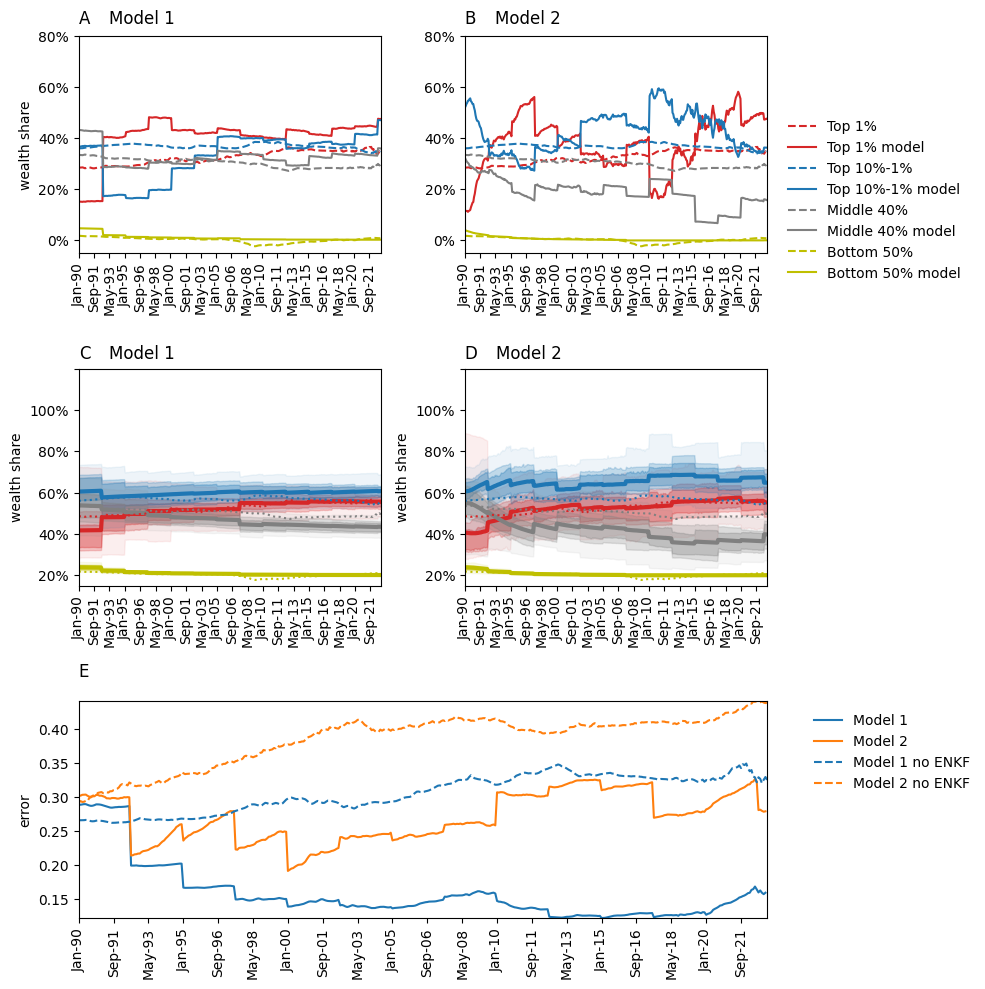

In [1]:
#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *
import import_ipynb
tqdm.pandas()

#%%


class Experiment1:
    def __init__(self, num_agents, ensemble_size, macro_state_dim, start_year, end_year, filter_freq):
        self.num_agents = num_agents
        self.ensemble_size = ensemble_size
        self.macro_state_dim = macro_state_dim
        self.enkf1 = None
        self.enkf2 = None
        self.start_year = start_year
        self.end_year = end_year

    def run_both_enkf(self, filter_freq):
        
        model_params1 = {"population_size": self.num_agents,
                        "growth_rate": 0.025,
                        "b_begin": 1.3,
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "uncertainty_para": 0.1}
        
        model_params2 = {"population_size": self.num_agents, 
                        "concavity": 1,
                        "growth_rate": 0.025, 
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "adaptive_sensitivity": 0.02,
                        "uncertainty_para": 0}

        
        self.enkf1 = prepare_enkf(Model1,
                                  model_params= model_params1,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        self.enkf2 = prepare_enkf(Model2,
                                   model_params= model_params2,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        run_enkf(self.enkf1, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)
        run_enkf(self.enkf2, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)

    def plot_results(self):

        fig = plt.figure(figsize=(10, 10))
        # Create a gridspec object
        gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
        # Create individual subplots
        ax0 = plt.subplot(gs[0, 0])
        ax1 = plt.subplot(gs[0, 1])
        ax2 = plt.subplot(gs[1, 0])
        ax3 = plt.subplot(gs[1, 1])
        ax4 = plt.subplot(gs[2, :])  # This one spans both columns

        
        self.enkf1.models[0].plot_wealth_groups_over_time(ax0, self.start_year, self.end_year)
        self.enkf2.models[0].plot_wealth_groups_over_time(ax1, self.start_year, self.end_year)
        self.enkf1.plot_fanchart(ax2)
        self.enkf2.plot_fanchart(ax3)        
        self.enkf1.plot_error(ax4)
        self.enkf2.plot_error(ax4)

        ###EXTRAS
        #AX0
        ax0.text(0, 0.85, 'A', fontsize = 12)
        ax0.text(40, 0.85, 'Model 1', fontsize = 12)
        #AX1
        ax1.legend(loc=(1.05, -0.15), frameon = False) ### legend only here
        ax1.text(0, 0.85, 'B', fontsize = 12)
        ax1.text(40, 0.85, 'Model 2', fontsize = 12)
        #AX2
        ax2.text(0, 1.05, 'C', fontsize = 12)
        ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
        ax2.text(40,1.05, 'Model 1', fontsize = 12)
        #AX3
        ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
        ax3.text(0,1.05, 'D', fontsize = 12)
        ax3.text(40,1.05, 'Model 2', fontsize = 12)

        path = '..'
        with open(os.path.join(path, 'data', 'mean_errors.csv')) as f:
            errors_df_no_enkf = pd.read_csv(f, encoding='unicode_escape')

        ax4.plot(errors_df_no_enkf['mean_error_model1'], linestyle='--', label='Model 1 no ENKF', color='tab:blue')
        ax4.plot(errors_df_no_enkf['mean_error_model2'], linestyle='--', label='Model 2 no ENKF', color='tab:orange')
        ax4.legend(bbox_to_anchor=(1.05, 1), frameon=False)
        
        # Get the limits
        x_min, x_max = ax4.get_xlim()
        y_min, y_max = ax4.get_ylim()
        ax4.text(0, y_max+0.02, 'E', fontsize = 12)
        ax4.margins(0)


        plt.tight_layout()
        plt.savefig('fig4.png', dpi=300)
        plt.show()
  
        
        
# Example usage
if __name__ == "__main__":
    filter_freq = 30
    experiment1 = Experiment1(num_agents=100, 
                              ensemble_size=100, 
                              macro_state_dim=4, 
                              start_year=1990,
                              end_year=2022,
                              filter_freq = filter_freq)
    experiment1.run_both_enkf(filter_freq = filter_freq)
    experiment1.plot_results()
    agent_states_model1 = experiment1.enkf1.micro_history
    agent_states_model2 = experiment1.enkf2.micro_history
    experiment1.enkf1.plot_macro_state()

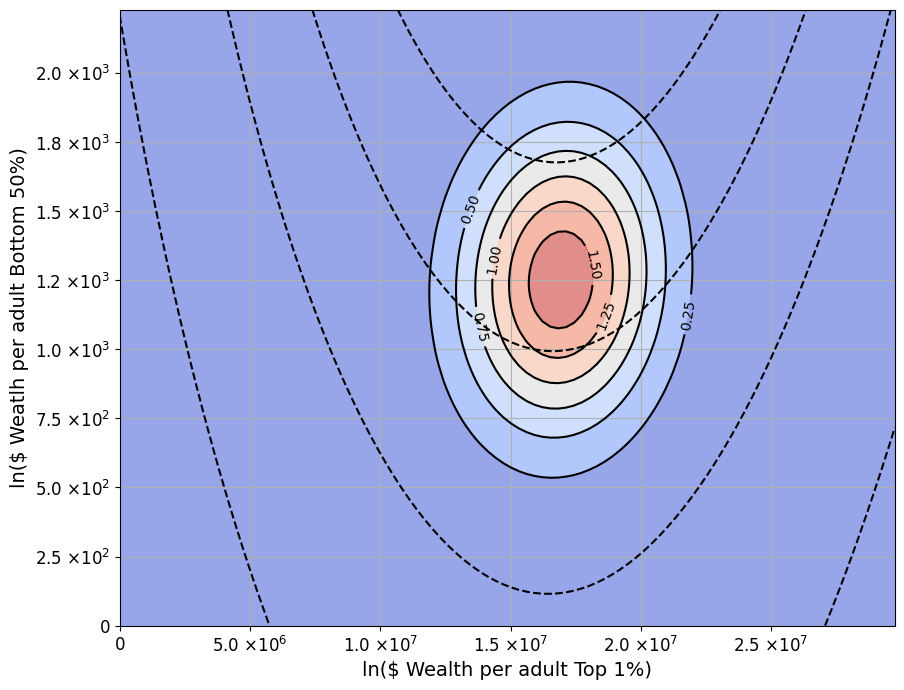

In [8]:
experiment1.enkf1.plot_macro_state(log_var = False)

## Plot agent-state variables and how the ENKF affects them

### Collect data from model 1

In [2]:
# Initialize an empty list to store the data
data = []
# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model1):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data.append(df)

# Concatenate the list into a single DataFrame
result_df = pd.concat(data, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df.columns = [f'ensemble_member_{i}' for i in range(result_df.shape[1] - 1)] + ['time_step']

print(result_df.head())


              0             1             2             3             4  \
0  2.381377e+06  1.267538e+06  3.787935e+06  2.568465e+07  3.373589e+06   
1  1.193346e+06  1.129647e+06  2.166357e+06  1.252307e+07  1.189234e+06   
2  9.643165e+05  9.350454e+05  1.433763e+06  2.586409e+06  1.050976e+06   
3  6.253619e+05  8.563340e+05  1.246810e+06  1.975719e+06  7.811942e+05   
4  6.091686e+05  7.820130e+05  1.226595e+06  1.437540e+06  7.247811e+05   

              5             6             7             8             9  ...  \
0  3.164401e+06  6.896715e+06  1.988198e+06  5.430568e+06  5.763564e+06  ...   
1  2.368762e+06  4.395215e+06  1.616483e+06  2.661679e+06  2.255997e+06  ...   
2  1.621352e+06  2.839238e+06  1.163418e+06  2.627198e+06  1.653557e+06  ...   
3  8.556278e+05  1.518020e+06  1.054039e+06  2.296383e+06  1.506869e+06  ...   
4  8.475478e+05  1.296574e+06  6.825759e+05  1.938330e+06  1.314511e+06  ...   

             91            92            93            94           

### Collect data from model 2

In [3]:
# Initialize an empty list to store the data
data_model2 = []

# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model2):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data_model2.append(df)

# Concatenate the list into a single DataFrame
result_df_model2 = pd.concat(data_model2, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df_model2.columns = [f'ensemble_member_{i}' for i in range(result_df_model2.shape[1] - 1)] + ['time_step']

print(result_df_model2.head())


              0             1             2             3             4  \
0  9.100299e+06  6.461944e+07  1.986798e+07  8.094068e+06  5.683412e+06   
1  2.412786e+06  9.828498e+06  1.109139e+07  4.734953e+06  5.273847e+06   
2  1.719769e+06  8.174916e+06  9.394699e+06  2.479510e+06  3.048407e+06   
3  1.518244e+06  6.593952e+06  6.635972e+06  2.991686e+06  2.894849e+06   
4  1.473665e+06  5.395566e+06  2.403243e+06  2.216269e+06  2.669785e+06   

              5             6             7             8             9  ...  \
0  1.878543e+07  4.014799e+06  5.086803e+06  5.449274e+06  4.161049e+06  ...   
1  4.107395e+06  3.751633e+06  3.299625e+06  4.346076e+06  3.569062e+06  ...   
2  3.159542e+06  3.220483e+06  1.492747e+06  3.045269e+06  2.840400e+06  ...   
3  3.135663e+06  2.620771e+06  1.285327e+06  3.084938e+06  2.175517e+06  ...   
4  2.712523e+06  2.356973e+06  9.793319e+05  2.532999e+06  1.840891e+06  ...   

             91            92            93            94           

## Try plotting average of ensembles evolution

C:\Users\yoswald\AppData\Local\Temp\ipykernel_16596\3828414789.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])
c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\yoswald\AppData\Local\Temp\ipykernel_16596\3828414789.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  re

Text(0.5, 1.0, 'Model 2')

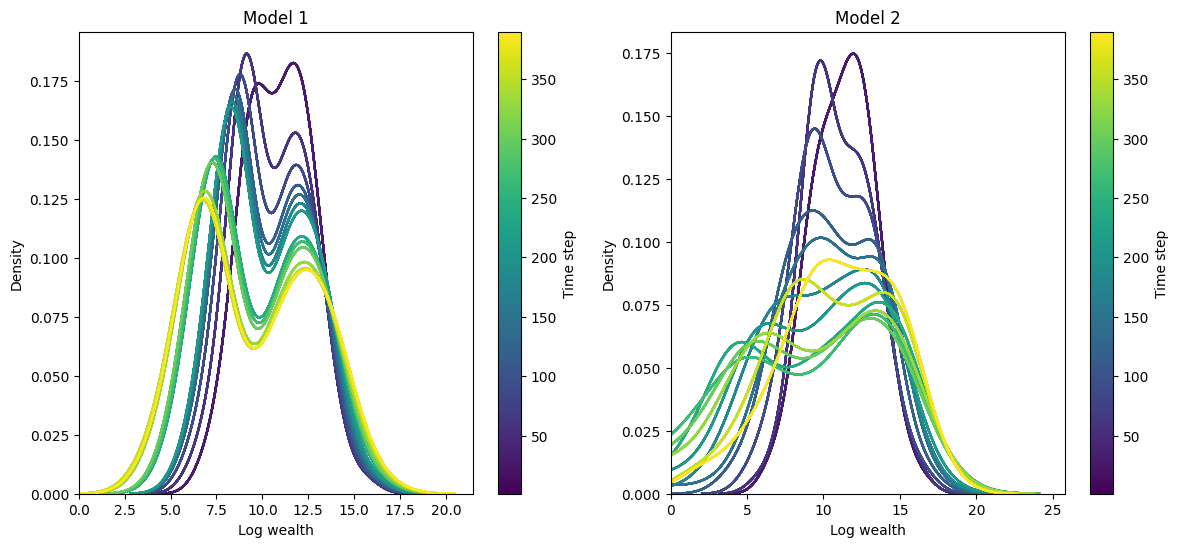

In [4]:

# import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# build average of all ensemble members
result_df['average_wealth'] = result_df.iloc[:, 1:-1].mean(axis=1)
result_df_avg = result_df[['time_step', 'average_wealth']]

# log transform the average data
result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])

# loop over time steps and plot all data as kernel density estimates with a colormap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)

for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg[result_df_avg['time_step'] == time_step]['log_wealth'], ax=ax1, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label('Time step')
ax1.set_xlabel('Log wealth')
ax1.set_ylabel('Density')
# set left x axis limit at 0
ax1.set_xlim(left=0)
ax1.set_title('Model 1')


## Model 2
# build average of all ensemble members
result_df_model2['average_wealth'] = result_df_model2.iloc[:, 1:-1].mean(axis=1)
result_df_avg_model2 = result_df_model2[['time_step', 'average_wealth']]
# log transform the average data
result_df_avg_model2['log_wealth'] = np.log(result_df_avg_model2['average_wealth'])

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)
for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg_model2[result_df_avg_model2['time_step'] == time_step]['log_wealth'], ax=ax2, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label('Time step')
ax2.set_xlabel('Log wealth')
ax2.set_ylabel('Density')
# set left x axis limit at 0
ax2.set_xlim(left=0)
ax2.set_title('Model 2')

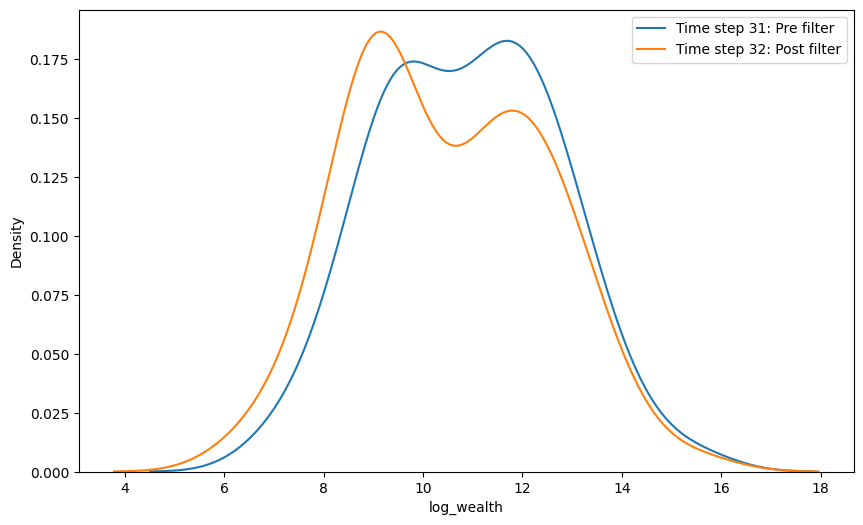

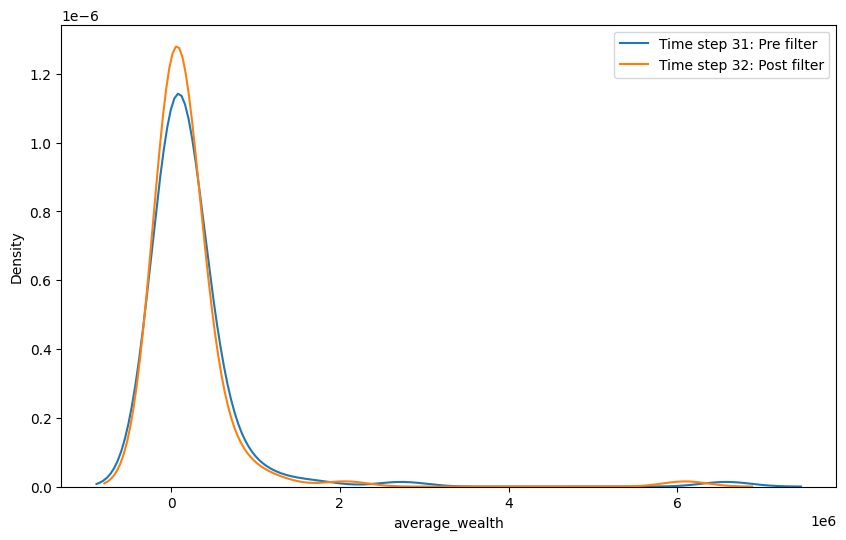

In [5]:
### plot time step 20 and 40 kernel density estimates of the log values
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 31]['log_wealth'], ax=ax, label='Time step 31: Pre filter', color='tab:blue')
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 32]['log_wealth'], ax=ax, label='Time step 32: Post filter', color='tab:orange')
# add a legend
ax.legend()

# for the same time steps plot non log values
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 31]['average_wealth'], ax=ax, label='Time step 31: Pre filter', color='tab:blue')
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 32]['average_wealth'], ax=ax, label='Time step 32: Post filter', color='tab:orange')
ax.legend()

